# Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from lh2pac.utils import update_default_inputs

from gemseo.algos.design_space import DesignSpace

from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

import pandas as pd
import matplotlib.pyplot as plt

from gemseo import to_pickle

configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [3]:
update_default_inputs(disciplines, {"fuel_type": "liquid_h2"})
disciplines[5].io.input_grammar.defaults

{'fuel_type': 'liquid_h2', 'gi': 0.4, 'tkv': 20.0}

# Create design space

In [4]:
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

# Create training and test dataset

In [5]:
training_dataset = sample_disciplines(disciplines, design_space, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

test_dataset = sample_disciplines(disciplines, design_space, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=20)

    INFO - 13:12:03: *** Start Sampling execution ***
    INFO - 13:12:03: Sampling
    INFO - 13:12:03:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 13:12:03:    MDO formulation: MDF
    INFO - 13:12:03: Running the algorithm OT_OPT_LHS:
    INFO - 13:12:03:    100%|██████████| 20/20 [00:00<00:00, 244.37 it/sec]
    INFO - 13:12:03: *** End Sampling execution (time: 0:00:00.090365) ***
    INFO - 13:12:03: *** Start Sampling execution ***
    INFO - 13:12:03: Sampling
    INFO - 13:12:03:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 13:12:03:    MDO formulation: MDF
    INFO - 13:12:03: Running the algorithm OT_MONTE_CARLO:
    INFO - 13:12:03:    100%|██████████| 20/20 [00:00<00:00, 301.62 it/sec]
    INFO - 13:12:03: *** End Sampling execution (time: 0:00:00.068942) ***


# Try different surrogate

 Testing surrogate: RBF_gaussian
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg3

Résultats comparatifs :
                     fm  length    mtom    span    tofl    vapp      vz
Model                                                                  
RBF_gaussian     0.8208  0.8077  0.8880  0.8524  0.7597  0.7812  0.8216
RBF_gaussian_mg  0.9876  0.9933  0.9825  0.9942  0.9873  0.9882  0.9836
Polynomial_deg2  0.9633  1.0000  0.9810  0.9988  0.9863  0.9968  0.9874
Polynomial_deg3  0.9405  0.9999  0.9652  0.9965  0.9858  0.9933  0.9712


<Figure size 1200x600 with 0 Axes>

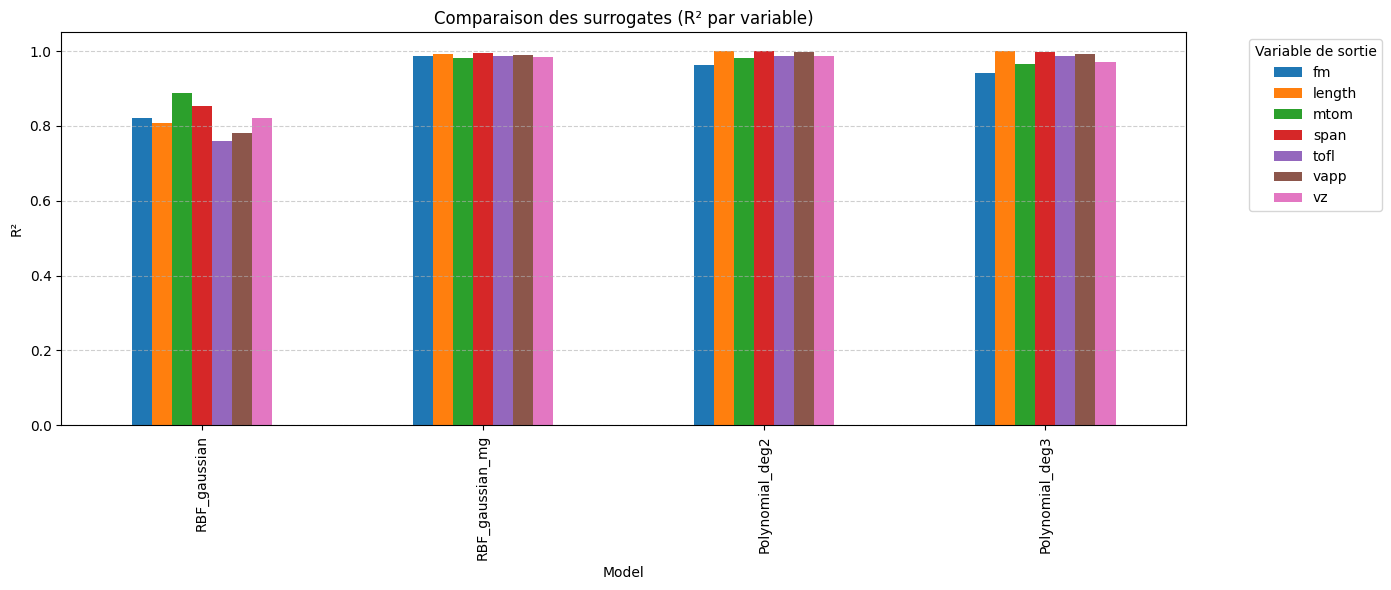

In [6]:
surrogate_configs = [
    {"name": "RBF_gaussian", "model": "RBFRegressor", "function": "gaussian"},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric"},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg3", "model": "PolynomialRegressor", "degree": 3},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save best surrogate

In [7]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", function="gaussian", data = training_dataset)

In [8]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.9405297]),
 'length': array([0.99989521]),
 'mtom': array([0.96519996]),
 'span': array([0.9965201]),
 'tofl': array([0.98577248]),
 'vapp': array([0.9932944]),
 'vz': array([0.97119482])}

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.09786111]),
 'length': array([1.45737431]),
 'mtom': array([1428.97068754]),
 'span': array([3.33344218]),
 'tofl': array([152.03251132]),
 'vapp': array([2.92512454]),
 'vz': array([1.75663787])}

In [10]:
to_pickle(surrogate_discipline, "UC2_my_surrogate_1.pkl")